In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import json, argparse
from include.utils import DotDic, plot_learning_curve

from include.TD3 import *
from Environment import Environment

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("--seed", default=13, type=int)
parser.add_argument("--gamma", default=0.99, type=float)
parser.add_argument("--polyak", default=0.995, type=float)
parser.add_argument("--policy_delay", default=2, type=float)
parser.add_argument("--policy_noise", default=0.2, type=float)
parser.add_argument("--noise_clip", default=0.5, type=float)
parser.add_argument('--lr', type=float, default=1e-3)  # learning rate
parser.add_argument("--batch_size", default=64, type=int)  # Batch size for both actor and critic
parser.add_argument('--actor_hidden', type=list, default=[400, 300])
parser.add_argument('--critic_hidden', type=list, default=[400, 300])
parser.add_argument('--model_path', type=str, default="./TD3 Training")

parser.add_argument('-c1', '--config_scenario', default='./configs/scenario.json', type=str, help='path to existing scenarionarios file')
args = parser.parse_args(args=[])

if not os.path.exists('%s/' % (args.model_path)):
  os.makedirs('%s/' % (args.model_path))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
scenario = DotDic(json.loads(open(args.config_scenario, 'r').read()))

In [3]:
# Environment action and states
K = scenario.K_t + scenario.K_r
L = scenario.L_t + scenario.L_r

# Actions: (Re{w_k}, Im{w_k}), (Re{u_l}, Im{u_l}), (theta_r, theta_t), rho_l
action_size =   (2 * K * scenario.Nt) + \
                (2 * L * scenario.Nt) + \
                (2 * scenario.R * scenario.Mr) + L

# States:  h, g, h_s, g_s, H, f, STR
state_size =    (scenario.Nt * K) + (scenario.Nt * L) + \
                (scenario.Mr * scenario.R * K) + \
                (scenario.Mr * scenario.R * L) + \
                (scenario.Mr * scenario.Nt * scenario.R) + \
                (L * K) + 1

max_action = 1

print(f'Action size is: {action_size}, \nState size is: {state_size}.')

Action size is: 131, 
State size is: 434.


In [4]:
# create the environment
env = Environment(scenario, state_size, action_size)
env_test = Environment(scenario, state_size, action_size)

# Create a DDPG instance
agent = TD3(state_size, action_size, max_action=1.0, args=args)
agent_test = TD3(state_size, action_size, max_action=1.0, args=args)

# for reproducibility
# env.set_seed(args.seed)
torch.manual_seed(args.seed)
# np.random.seed(args.seed)

noise_var = 1.0
noise_decay = 0.99993 * max_action

## Train

In [5]:
ep_r = 0
score_hist = []

max_episode = 100
max_steps = 300
trainig_iteration = 32

# Train the agent for max_episodes
for e in range(max_episode):
    done = 0
    total_reward = 0
    state = env.reset()
    
    print(f'Training: \n\t episode {e+1}/{max_episode} ...')
    for t in range(max_steps):

        noise_var = noise_var * noise_decay
        exploration_noise = np.random.normal(0, noise_var, size=action_size)

        action = agent.select_action(state)
        action = action + exploration_noise
        action = action.clip(-max_action, max_action)
            
        phi_r, phi_t, rho, w, u = env.action_cal(action)
        next_state, reward, done, info = env.step(phi_r, phi_t, rho, w, u)

        agent.replay_buffer.add((state, next_state, action, reward, done))
        agent.train(trainig_iteration)
        
        state = next_state
        total_reward += reward

        if done:
            print(f'\t done in step {t+1}')
            break
        elif t==max_steps-1:
            print('\t Not done !')
        
        
    score_hist.append(total_reward)

    print("\t Total Reward: {:0.2f} ".format(total_reward))
    
    
    if e % 10 == 0:
        agent.save()

Training: 
	 episode 1/100 ...
	 done in step 3
	 Total Reward: -17098185.70 
Training: 
	 episode 2/100 ...
	 done in step 2
	 Total Reward: 33579.62 
Training: 
	 episode 3/100 ...
	 done in step 10
	 Total Reward: -91345013.11 
Training: 
	 episode 4/100 ...
	 done in step 9
	 Total Reward: -73423313.27 
Training: 
	 episode 5/100 ...
	 done in step 2
	 Total Reward: -5504586.65 
Training: 
	 episode 6/100 ...
	 done in step 1
	 Total Reward: 6787361.06 
Training: 
	 episode 7/100 ...
	 done in step 2
	 Total Reward: -4191896.17 
Training: 
	 episode 8/100 ...
	 done in step 14
	 Total Reward: -134949590.25 
Training: 
	 episode 9/100 ...
	 done in step 13
	 Total Reward: -123017423.79 
Training: 
	 episode 10/100 ...
	 done in step 7
	 Total Reward: -52458458.78 
Training: 
	 episode 11/100 ...
	 done in step 3
	 Total Reward: -17810104.09 
Training: 
	 episode 12/100 ...
	 done in step 2
	 Total Reward: -2247719.73 
Training: 
	 episode 13/100 ...
	 done in step 6
	 Total Reward: 

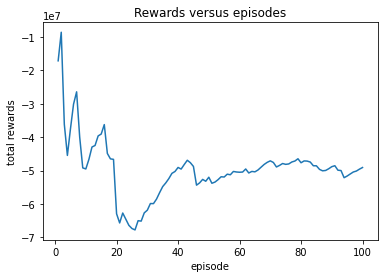

In [6]:
plot_learning_curve(score_hist)

## Test

In [8]:
test_episode = 200
max_steps = 300
score_hist_test = []


for e in range(test_episode):
    TR = 0
    done = 0
    total_reward = 0
    state = env_test.reset()
    agent_test.load()

    print(f'Testing: \n\t episode {e+1}/{test_episode} ...')
    for t in range(max_steps):

        noise_var = noise_var * noise_decay
        exploration_noise = np.random.normal(0, noise_var, size=action_size)

        action = agent.select_action(state)
        action = action + exploration_noise
        action = action.clip(-max_action, max_action)
             
        phi_r, phi_t, rho, w, u = env.action_cal(action)
        next_state, reward, done, info = env.step(phi_r, phi_t, rho, w, u)

        state = next_state

        TR = info['TR']

        total_reward += reward

        if done:
            print(f'\t done in step {t+1}')
            break
        elif t==max_steps-1:
            print('\t Not done !')
        
    score_hist_test.append(total_reward)

    print("\t Total Reward: {:0.2f} ".format(total_reward))

Testing: 
	 episode 1/200 ...
	 done in step 8
	 Total Reward: -66948801.28 
Testing: 
	 episode 2/200 ...
	 done in step 1
	 Total Reward: 6675197.49 
Testing: 
	 episode 3/200 ...
	 done in step 6
	 Total Reward: -52950033.81 
Testing: 
	 episode 4/200 ...
	 done in step 1
	 Total Reward: 6877612.82 
Testing: 
	 episode 5/200 ...
	 done in step 2
	 Total Reward: -1889506.87 
Testing: 
	 episode 6/200 ...
	 done in step 4
	 Total Reward: -25352363.87 
Testing: 
	 episode 7/200 ...
	 done in step 9
	 Total Reward: -79500448.67 
Testing: 
	 episode 8/200 ...
	 done in step 2
	 Total Reward: -3843319.61 
Testing: 
	 episode 9/200 ...
	 done in step 2
	 Total Reward: -3384192.14 
Testing: 
	 episode 10/200 ...
	 done in step 3
	 Total Reward: -11622594.35 
Testing: 
	 episode 11/200 ...
	 done in step 1
	 Total Reward: 6768419.60 
Testing: 
	 episode 12/200 ...
	 done in step 4
	 Total Reward: -29821592.19 
Testing: 
	 episode 13/200 ...
	 done in step 2
	 Total Reward: -4642374.23 
Testi

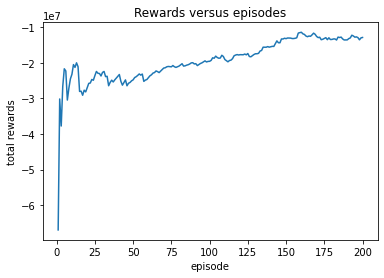

In [9]:
plot_learning_curve(score_hist_test)